In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import lightgbm as lgb

warnings.filterwarnings('ignore')

In [2]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [3]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features] 
    # features = [col for col in list(df) if col in keep_5_features] 
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [4]:
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

In [5]:
########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = True               # Use or not pretrained models


if USE_AUX:
    lgb_params['n_estimators'] = 2


#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features     = ['id','state_id','store_id',
                       'date','wm_yr_wk','d',TARGET]
keep_5_features     = ['tm_d' 'rolling_std_180' 'tm_w' 'rolling_mean_180' 'item_id']
keep_10_features    = ['rolling_mean_tmp_1_7' 'rolling_mean_60' 'enc_item_id_mean'
                       'rolling_std_30' 'rolling_std_60' 'tm_d' 'rolling_std_180' 'tm_w'
                       'rolling_mean_180' 'item_id']
mean_features       = ['enc_cat_id_mean','enc_cat_id_std',
                       'enc_dept_id_mean','enc_dept_id_std',
                       'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE     = '../input/m5-simple-fe/grid_part_1.pkl'
PRICE    = '../input/m5-simple-fe/grid_part_2.pkl'
CALENDAR = '../input/m5-simple-fe/grid_part_3.pkl'
LAGS     = '../input/m5-lags-features/lags_df_28.pkl'
MEAN_ENC = '../input/m5-custom-features/mean_encoding_df.pkl'


# AUX(pretrained) Models paths
AUX_MODELS = '../input/m5-aux-models/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [9]:
########################### Train Models
#################################################################################
for store_id in STORES_IDS:
    print('Train', store_id)
    
    # Get grid for current store
    grid_df, features_columns = get_data_by_store(store_id)
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                       label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle('test_'+store_id+'.pkl')
    del grid_df
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,
                          train_data,
                          valid_sets = [valid_data],
                          verbose_eval = 100,
                          )
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
    pickle.dump(estimator, open(model_name, 'wb'))

    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

Train CA_1


KeyboardInterrupt: 

In [ ]:
########################### Predict 
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = get_base_test()

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
        
    for store_id in STORES_IDS:
        
        # Read all our models and make predictions
        # for each day/store pairs
        model_path = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
        if USE_AUX:
            model_path = AUX_MODELS + model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
    
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

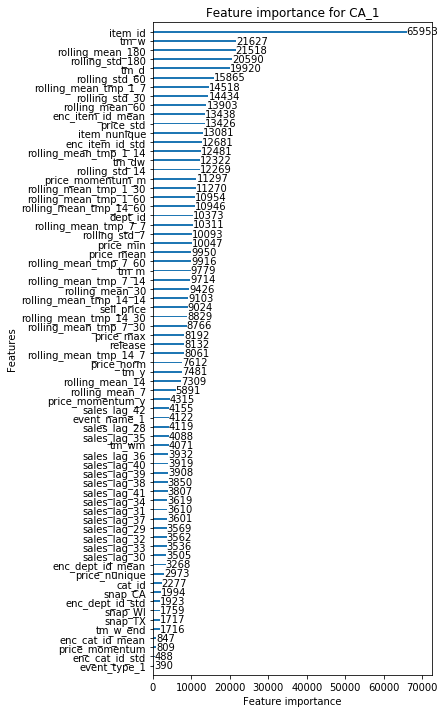

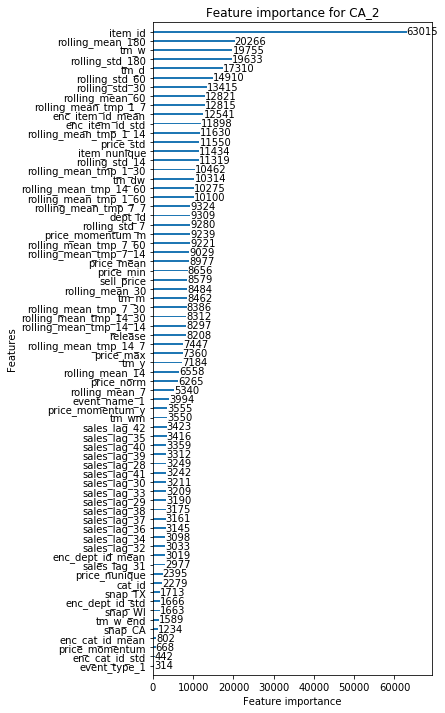

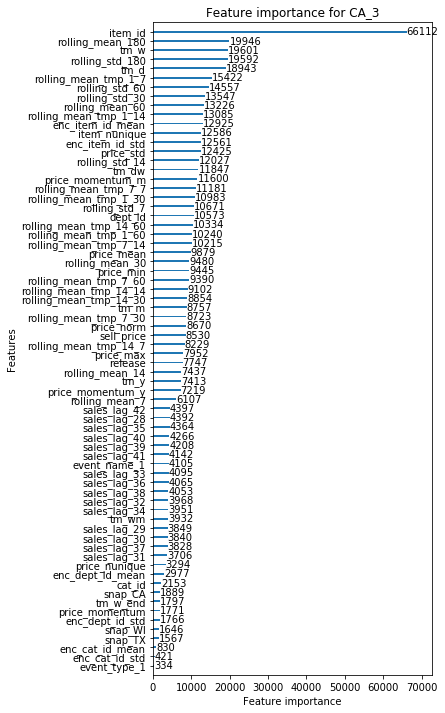

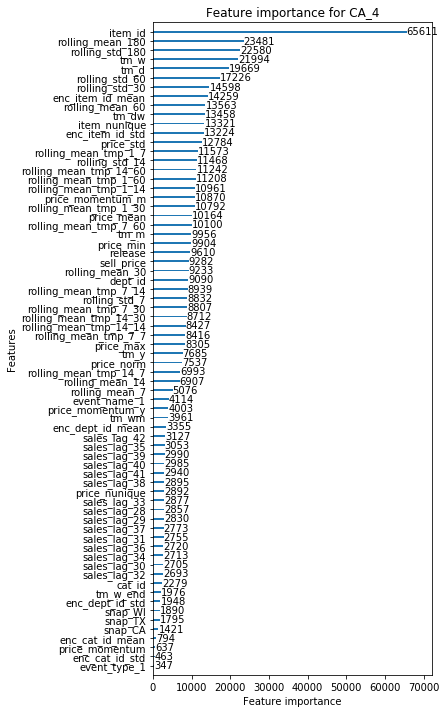

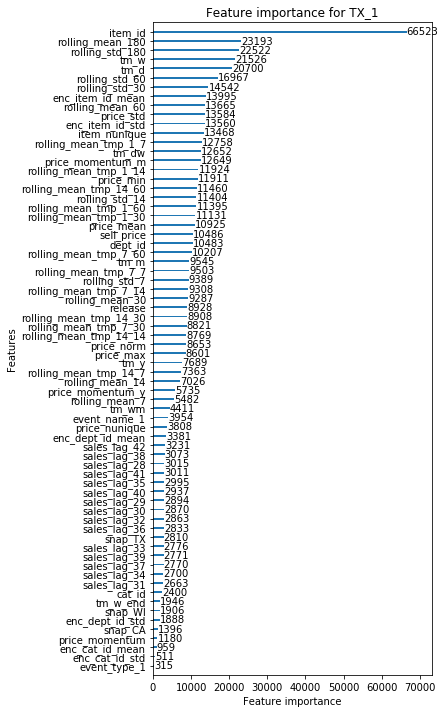

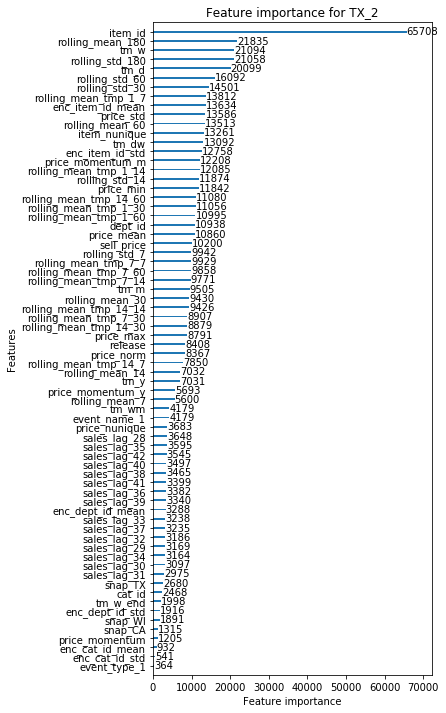

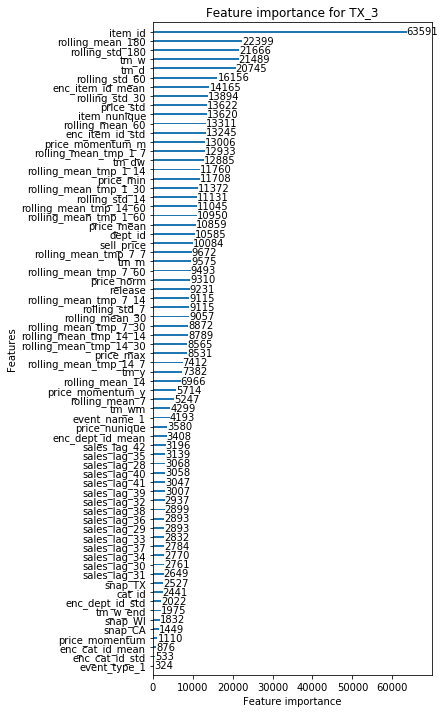

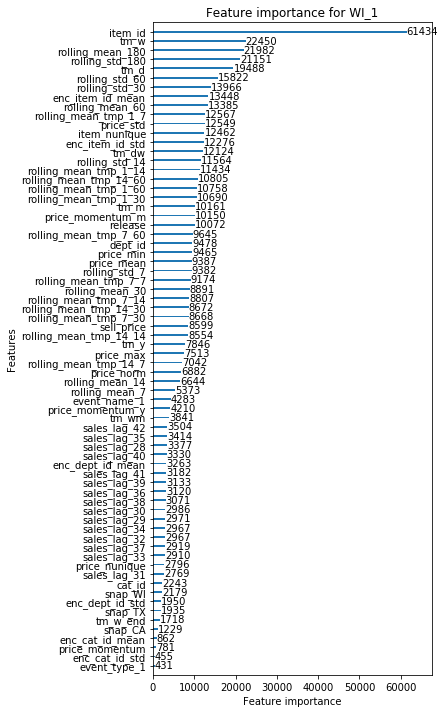

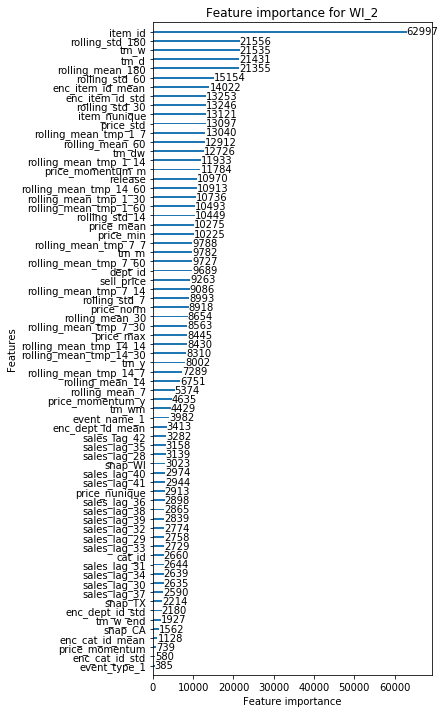

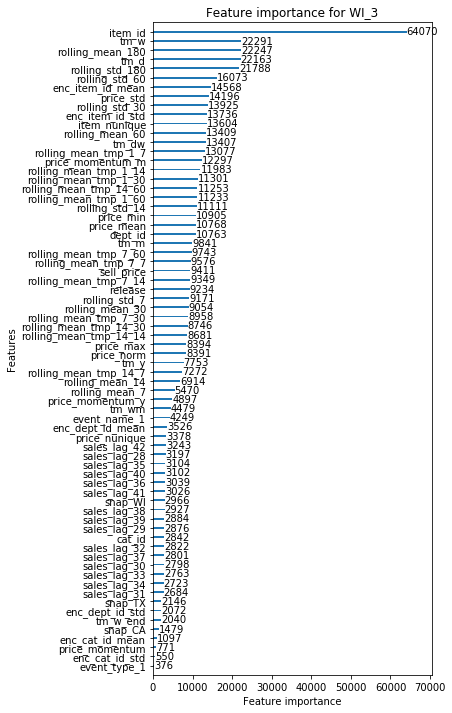

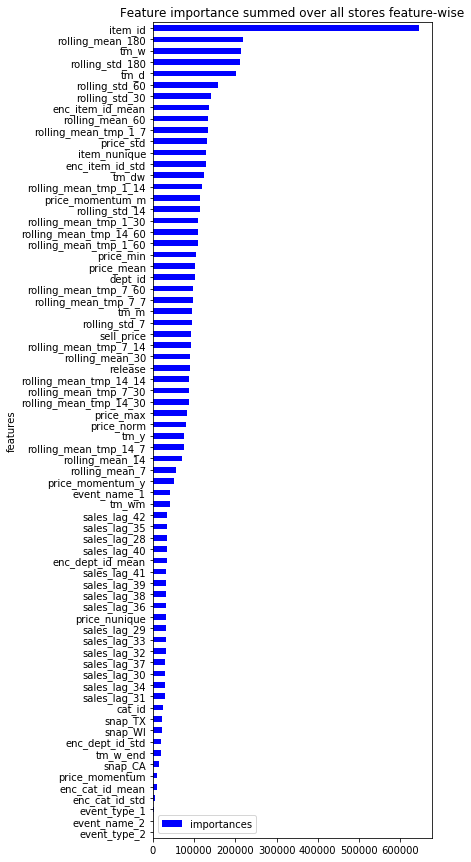

In [33]:
########################### See feature importance
#################################################################################

FEATURES = ['item_id', 'dept_id', 'cat_id', 'release', 'sell_price', 'price_max', 'price_min', 'price_std', 'price_mean', 'price_norm', 'price_nunique', 'item_nunique', 'price_momentum', 'price_momentum_m', 'price_momentum_y', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'enc_cat_id_mean', 'enc_cat_id_std', 'enc_dept_id_mean', 'enc_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std', 'sales_lag_28', 'sales_lag_29', 'sales_lag_30', 'sales_lag_31', 'sales_lag_32', 'sales_lag_33', 'sales_lag_34', 'sales_lag_35', 'sales_lag_36', 'sales_lag_37', 'sales_lag_38', 'sales_lag_39', 'sales_lag_40', 'sales_lag_41', 'sales_lag_42', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60', 'rolling_std_60', 'rolling_mean_180', 'rolling_std_180', 'rolling_mean_tmp_1_7', 'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30', 'rolling_mean_tmp_1_60', 'rolling_mean_tmp_7_7', 'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30', 'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7', 'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30', 'rolling_mean_tmp_14_60']

# Plot feature importance for every store model 

feature_importances = np.zeros(72,)

for store_id in STORES_IDS:
        # Read all our models and make predictions
        # for each day/store pairs
        model_path = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 

        if USE_AUX:
            model_path = AUX_MODELS + model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        values = np.array(estimator.feature_importance())
        feature_importances = np.add(feature_importances, values)

        ax = lgb.plot_importance(estimator, title=f'Feature importance for {store_id}', grid=False, figsize=(5, 12))
        plt.show()

df = pd.DataFrame({'features':FEATURES,'importances':feature_importances})
df.sort_values('importances',inplace=True)
df.plot(kind='barh', 
        y='importances', 
        x='features', 
        color='b', 
        figsize=(5, 15), 
        title='Feature importance summed over all stores feature-wise')


In [51]:
print(df.features.to_numpy()[-10:])

['rolling_mean_tmp_1_7' 'rolling_mean_60' 'enc_item_id_mean'
 'rolling_std_30' 'rolling_std_60' 'tm_d' 'rolling_std_180' 'tm_w'
 'rolling_mean_180' 'item_id']


In [7]:
########################### PCA

for store_id in STORES_IDS:
    print(f'Currently performing PCA on following store: {store_id}')
    
    # Get grid for current store
    grid_df, features_columns = get_data_by_store(store_id)
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)

    train_data = grid_df[train_mask][features_columns]

    pca = PCA()
    pca.fit(train_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1

    print(f'Number of dimension to keep 95% of variance is {d} dimensions.')

    plt.plot(cumsum)
    plot.show()

    break;
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    # train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
    #                    label=grid_df[train_mask][TARGET])
    # train_data.save_binary('train_data.bin')
    # train_data = lgb.Dataset('train_data.bin')
    
    # valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
    #                    label=grid_df[valid_mask][TARGET])
    
    

    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    # grid_df = grid_df[preds_mask].reset_index(drop=True)
    # keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    # grid_df = grid_df[keep_cols]
    # grid_df.to_pickle('test_'+store_id+'.pkl')
    # del grid_df
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    # seed_everything(SEED)
    # estimator = lgb.train(lgb_params,
    #                       train_data,
    #                       valid_sets = [valid_data],
    #                       verbose_eval = 100,
    #                       )
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    # model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
    # pickle.dump(estimator, open(model_name, 'wb'))

    # # Remove temporary files and objects 
    # # to free some hdd space and ram memory
    # !rm train_data.bin
    # del train_data, valid_data, estimator
    # gc.collect()
    
    # # "Keep" models features for predictions
    # MODEL_FEATURES = features_columns

Currently performing PCA on following store: CA_1


ValueError: could not convert string to float: 'HOBBIES_1_008'

In [55]:
# grid_df, features_columns = get_data_by_store('CA_1')

train_mask = grid_df['d']<=END_TRAIN
valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
preds_mask = grid_df['d']>(END_TRAIN-100)

grid_df = grid_df.dropna()

train_data = grid_df[train_mask][features_columns]
valid_data = grid_df[valid_mask][features_columns]

In [56]:
train_data = train_data.drop(columns=['dept_id', 'cat_id', 'release', 'item_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])
valid_data = valid_data.drop(columns=['dept_id', 'cat_id', 'release', 'item_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])

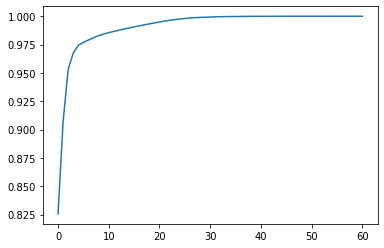

In [26]:
pca = PCA()
pca.fit(train_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)
plt.show()

In [52]:
pca = PCA(n_components=0.98)
train_data_reduced = pca.fit_transform(train_data)
valid_data_reduced = pca.fit_transform(valid_data)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [38]:
train_data = lgb.Dataset(train_data_reduced, 
                    label=grid_df[train_mask][TARGET])

valid_data = lgb.Dataset(valid_data_reduced, 
                    label=grid_df[valid_mask][TARGET])

In [42]:
grid_df = grid_df[preds_mask].reset_index(drop=True)
keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
grid_df = grid_df[keep_cols]
grid_df.to_pickle('test_CA_1_pca.pkl')
del grid_df

# Launch seeder again to make lgb training 100% deterministic
# with each "code line" np.random "evolves" 
# so we need (may want) to "reset" it
seed_everything(SEED)
estimator = lgb.train(lgb_params,
                        train_data,
                        valid_sets = [valid_data],
                        verbose_eval = 100,
                        )

# Save model - it's not real '.bin' but a pickle file
# estimator = lgb.Booster(model_file='model.txt')
# can only predict with the best iteration (or the saving iteration)
# pickle.dump gives us more flexibility
# like estimator.predict(TEST, num_iteration=100)
# num_iteration - number of iteration want to predict with, 
# NULL or <= 0 means use best iteration
model_name = 'lgb_model_'+store_id+'_pca_v'+str(VER)+'.bin'
pickle.dump(estimator, open(model_name, 'wb'))

# Remove temporary files and objects 
# to free some hdd space and ram memory
del train_data, valid_data, estimator
gc.collect()

# "Keep" models features for predictions
MODEL_FEATURES = features_columns

LightGBMError: Length of label is not same with #data